# Correlação entre as variáveis

O objetivo desse notebook é avaliar se existe alguma correlação entre as variáveis entre si por meio da matriz de correlação.

In [67]:
from commpy.channels import awgn
import numpy as np
import matplotlib.pyplot as plt
import pyMRI.pymri as pymri
from pyMRI.utils import RMSE
import seaborn as sns
from typing import Literal

In [68]:
metabolites = pymri.METABOLITES
met_i = 1

t0, tn, dt, B0 = pymri.setup_sim_t(0.0, 1.0, 2048, 3.0)

ws, t2s, M_0s = pymri.unpack_metabolites(metabolites, B0)
ws, t2s, M_0s = ws[met_i:met_i + 1], t2s[met_i:met_i + 1], M_0s[met_i:met_i + 1]
spins_phi = np.zeros_like(M_0s)

rcond = 1e-7 
zero_filtering = 1e-14

print( "All frequencies are captured by the sampling rate." if pymri.check_frequency(ws, dt) == True 
      else f"At least one frequency is NOT captured by the sampling rate")

All frequencies are captured by the sampling rate.


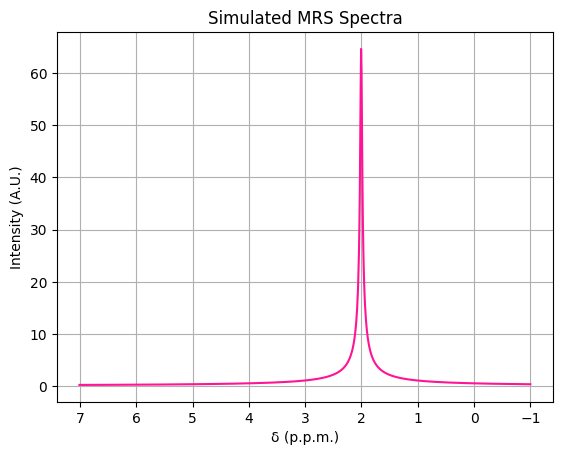

In [69]:
pop = pymri.population(ws, t2s, M_0s, spins_phi)

sig, t = pymri.population_transverse_decay( t0, tn, dt, pop, np.array([]) )
freqs, sig_fft = pymri.fourier_spectrum( sig, dt, B0 )

pymri.plot_chem_shifts(freqs, sig_fft, 1.0)

In [70]:
L = 0.4
noise_threshold = 1e-30
rcond=noise_threshold
L_ = int(L*sig.size)

In [71]:
sample_snrs = np.array([0.25, 0.50, 0.75, 1.0, 2.5, 5.0, 10.0, 25.0, 50.0, 75.0, 100.0])

In [72]:
n_avgs = 10
shape = (sample_snrs.size, n_avgs, L_)
s0s_, phis_, omegas_, t2s_ = np.zeros(shape), np.zeros(shape), np.zeros(shape), np.zeros(shape)
original_c_sigs = np.zeros((sample_snrs.size, n_avgs, 2048), dtype=np.complex128)

In [73]:
rerun = False
filename_end = "_offsets"
folder_name = "files/"
subfolder_name = "variables_correlation/"

In [74]:
pop = pymri.population(ws, t2s, M_0s, spins_phi)
sig, t = pymri.population_transverse_decay(t0, tn, dt, pop)
freqs, sig_fft = pymri.fourier_spectrum( sig, dt, B0 )
sig_fft_ = sig_fft/np.nanmax(sig_fft)

if rerun == True:
    for j in range(n_avgs):
        for i in range(sample_snrs.size):

            c_sig_fft = awgn(sig_fft_, sample_snrs[i])
            original_c_sigs[i, j, :] = np.fft.ifft(np.fft.ifftshift(c_sig_fft))
            
            f_sig, z, r = pymri.filter_sig(original_c_sigs[i, j, :], L, noise_threshold, 
                                        return_poles_and_res=True, 
                                        return_full_arrays=True, 
                                        rcond=noise_threshold, 
                                        zero_filtering=noise_threshold)
            s0s_[i, j, :], phis_[i, j, :], omegas_[i, j, :], t2s_[i, j, :] = pymri.calculate_variables_from_z_and_r(z, r, dt)
            t2s_[i, j, :] = 1/t2s_[i, j, :]

In [75]:
if rerun == True:
    np.save(folder_name + subfolder_name + "s0s_" + filename_end, s0s_)
    np.save(folder_name + subfolder_name + "phis_" + filename_end, phis_)
    np.save(folder_name + subfolder_name + "omegas_" + filename_end, omegas_)
    np.save(folder_name + subfolder_name + "t2s_" + filename_end, t2s_)
    np.save(folder_name + subfolder_name + "original_c_sigs" + filename_end, original_c_sigs)

In [76]:
if rerun == False:
    s0s_            = np.load(folder_name + subfolder_name + "s0s_" + filename_end + ".npy")
    phis_           = np.load(folder_name + subfolder_name + "phis_" + filename_end + ".npy")
    omegas_         = np.load(folder_name + subfolder_name + "omegas_" + filename_end + ".npy")
    t2s_            = np.load(folder_name + subfolder_name + "t2s_" + filename_end + ".npy")
    original_c_sigs = np.load(folder_name + subfolder_name + "original_c_sigs" + filename_end + ".npy")


## Coeficiente de Pearson para Variáveis

In [77]:
k_ = 0
s0_mat = s0s_[:, :, k_]
phis_mat = phis_[:, :, k_]
omegas_mat = omegas_[:, :, k_]
t2s_mat = t2s_[:, :, k_]

In [78]:

s0_phi, s0_omega, s0_t2, phi_omega, phi_t2, omega_t2 = np.zeros(L_), np.zeros(L_), np.zeros(L_), np.zeros(L_), np.zeros(L_), np.zeros(L_)
for k in range(L_):
    s0_mat = s0s_[:, :, k]
    phis_mat = phis_[:, :, k]
    omegas_mat = omegas_[:, :, k]
    t2s_mat = t2s_[:, :, k]
    variables_mat = np.array([s0_mat.flatten(), phis_mat.flatten(), omegas_mat.flatten(), t2s_mat.flatten()])
    corr = np.corrcoef(variables_mat)
    s0_phi[k] = corr[0, 1]
    s0_omega[k] = corr[0, 2]
    s0_t2[k] = corr[0, 3]
    phi_omega[k] = corr[1, 2]
    phi_t2[k] = corr[1, 3]
    omega_t2[k] = corr[2, 3]


# corr = np.corrcoef(variables_mat)

# print(corr)

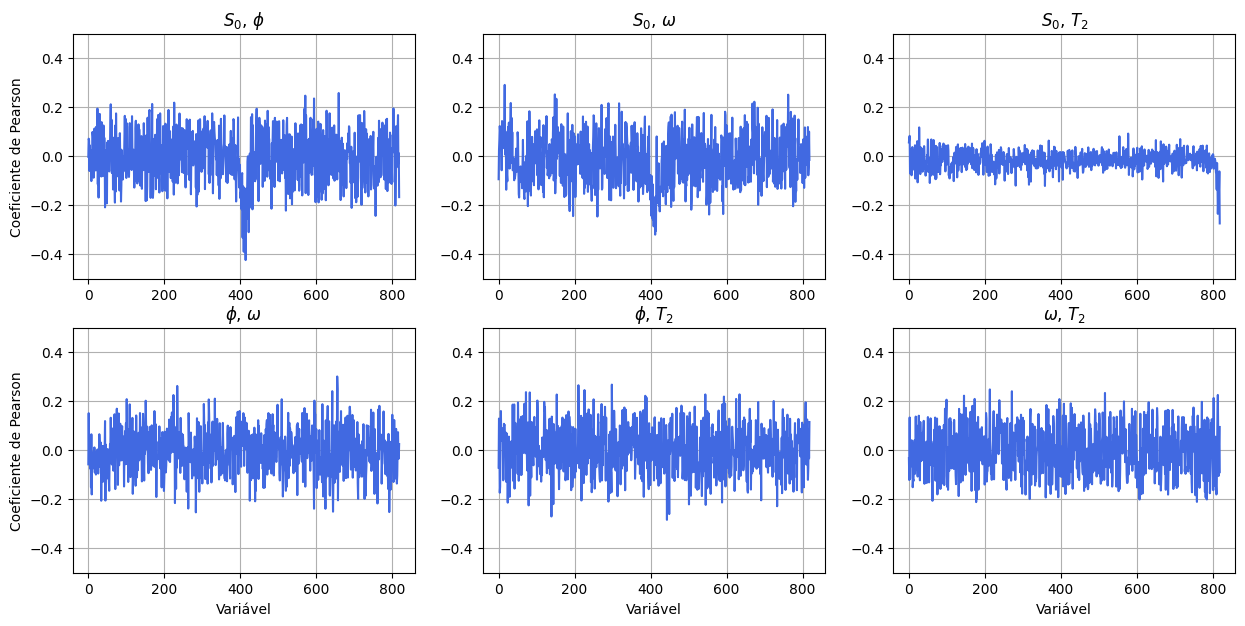

In [79]:
k_arr = np.arange(0, L_)

plt.figure(figsize=(15, 7))

plt.subplot(231)
plt.plot(k_arr, s0_phi, c = "royalblue")
plt.title(r"$S_0$, $\phi$")
# plt.xlabel("Variável")
plt.ylim(-0.5, 0.5)
plt.ylabel("Coeficiente de Pearson")
plt.grid()

plt.subplot(232)
plt.plot(k_arr, s0_omega, c = "royalblue")
plt.title(r"$S_0$, $\omega$")
plt.ylim(-0.5, 0.5)
# plt.xlabel("Variável")
# plt.ylabel("Coeficiente de Pearson")
plt.grid()

plt.subplot(233)
plt.plot(k_arr, s0_t2, c = "royalblue")
plt.title(r"$S_0$, $T_2$")
plt.ylim(-0.5, 0.5)
# plt.xlabel("Variável")
# plt.ylabel("Coeficiente de Pearson")
plt.grid()

plt.subplot(234)
plt.plot(k_arr, phi_omega, c = "royalblue")
plt.title(r"$\phi$, $\omega$")
plt.ylim(-0.5, 0.5)
plt.xlabel("Variável")
plt.ylabel("Coeficiente de Pearson")
plt.grid()

plt.subplot(235)
plt.plot(k_arr, phi_t2, c = "royalblue")
plt.title(r"$\phi$, $T_2$")
plt.ylim(-0.5, 0.5)
plt.xlabel("Variável")
# plt.ylabel("Coeficiente de Pearson")
plt.grid()

plt.subplot(236)
plt.plot(k_arr, omega_t2, c = "royalblue")
plt.title(r"$\omega$, $T_2$")
plt.ylim(-0.5, 0.5)
plt.xlabel("Variável")
# plt.ylabel("Coeficiente de Pearson")
plt.grid()

## Coeficiente de Pearson para SNR

In [80]:
n = sample_snrs.size
s0_phi, s0_omega, s0_t2, phi_omega, phi_t2, omega_t2 = np.zeros(n), np.zeros(n), np.zeros(n), np.zeros(n), np.zeros(n), np.zeros(n)
for i in range(n):
    s0_mat = s0s_[i, :, :]
    phis_mat = phis_[i, :, :]
    omegas_mat = omegas_[i, :, :]
    t2s_mat = t2s_[i, :, :]
    variables_mat = np.array([s0_mat.flatten(), phis_mat.flatten(), omegas_mat.flatten(), t2s_mat.flatten()])
    corr = np.corrcoef(variables_mat)
    s0_phi[i] = corr[0, 1]
    s0_omega[i] = corr[0, 2]
    s0_t2[i] = corr[0, 3]
    phi_omega[i] = corr[1, 2]
    phi_t2[i] = corr[1, 3]
    omega_t2[i] = corr[2, 3]

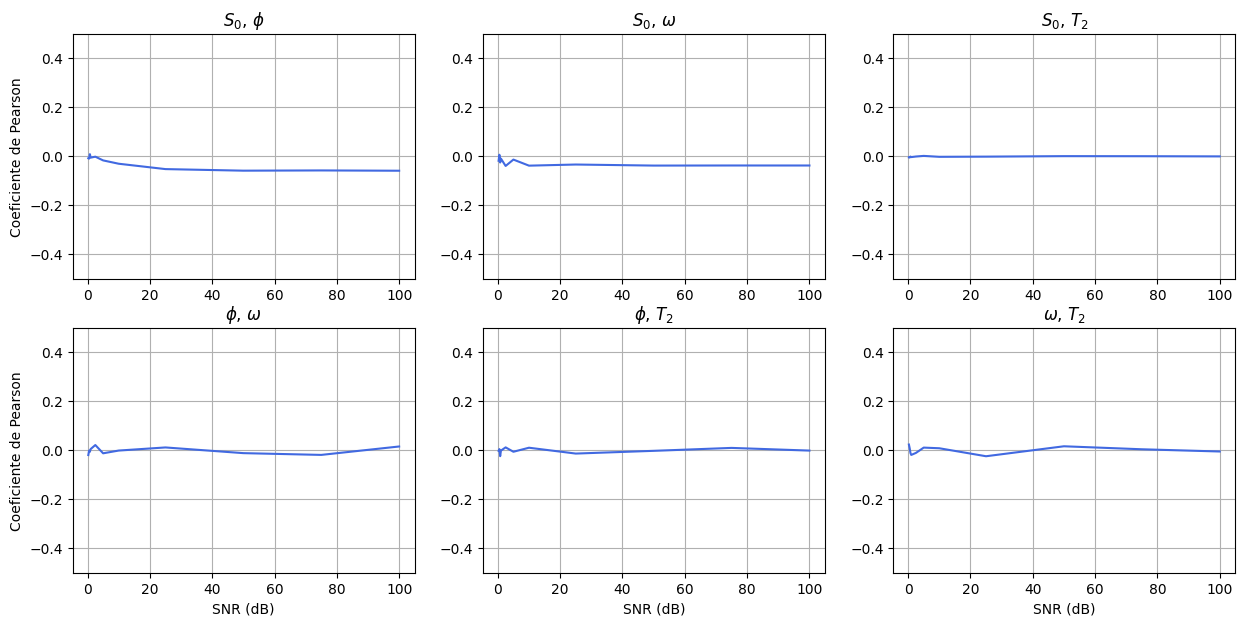

In [81]:
plt.figure(figsize=(15, 7))

plt.subplot(231)
plt.plot(sample_snrs, s0_phi, c = "royalblue")
plt.title(r"$S_0$, $\phi$")
# plt.xlabel("Variável")
plt.ylim(-0.5, 0.5)
plt.ylabel("Coeficiente de Pearson")
plt.grid()

plt.subplot(232)
plt.plot(sample_snrs, s0_omega, c = "royalblue")
plt.title(r"$S_0$, $\omega$")
plt.ylim(-0.5, 0.5)
# plt.xlabel("Variável")
# plt.ylabel("Coeficiente de Pearson")
plt.grid()

plt.subplot(233)
plt.plot(sample_snrs, s0_t2, c = "royalblue")
plt.title(r"$S_0$, $T_2$")
plt.ylim(-0.5, 0.5)
# plt.xlabel("Variável")
# plt.ylabel("Coeficiente de Pearson")
plt.grid()

plt.subplot(234)
plt.plot(sample_snrs, phi_omega, c = "royalblue")
plt.title(r"$\phi$, $\omega$")
plt.ylim(-0.5, 0.5)
plt.xlabel("SNR (dB)")
plt.ylabel("Coeficiente de Pearson")
plt.grid()

plt.subplot(235)
plt.plot(sample_snrs, phi_t2, c = "royalblue")
plt.title(r"$\phi$, $T_2$")
plt.ylim(-0.5, 0.5)
plt.xlabel("SNR (dB)")
# plt.ylabel("Coeficiente de Pearson")
plt.grid()

plt.subplot(236)
plt.plot(sample_snrs, omega_t2, c = "royalblue")
plt.title(r"$\omega$, $T_2$")
plt.ylim(-0.5, 0.5)
plt.xlabel("SNR (dB)")
# plt.ylabel("Coeficiente de Pearson")
plt.grid()

Talvez valha a pena fazer um coeficiente de spearman? Tem no scipy.